In [1]:
!pip install -q transformers seqeval

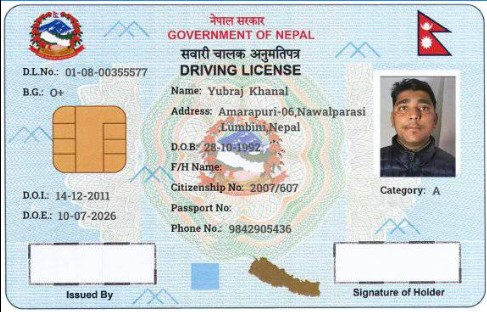

In [2]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("training_data/images/1.jpg")
image = image.convert("RGB")
image

In [3]:
image.size

(487, 312)

In [4]:
import json

with open('training_data/annotations/1.json') as f:
    data = json.load(f)
    
words = []
bounding_boxes = []
labels = []

for label in data['label']:
    bounding_boxes.append([label["x"] * label["original_width"] / 100, label["y"] * label["original_height"] / 100, (label["x"] + label["width"]) * label["original_width"] / 100, (label["y"] + label["height"]) * label["original_height"] / 100])
    labels.append(label["labels"][0])

for transcription in data['transcription']:
    words.append(transcription)
    
print("Words:", words)
print("Bounding boxes:", bounding_boxes)
print("Labels:", labels)

Words: ['01-08-00355577', 'Yubraj Khanal', '28-10-1992']
Bounding boxes: [[62.68493150684932, 64.82191780821918, 152.43835616438358, 81.2054794520548], [208.0, 83.34246575342466, 297.04109589041093, 98.30136986301372], [200.1643835616439, 139.6164383561644, 277.8082191780822, 156.71232876712332]]
Labels: ['LiscenseNo', 'Name', 'DOB']


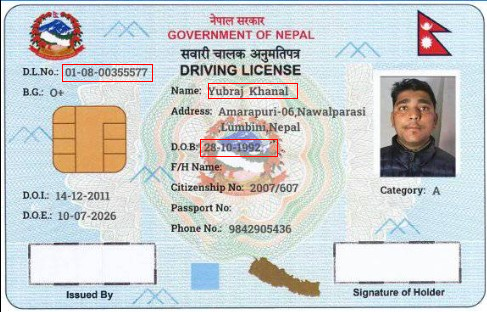

In [5]:
image_with_bboxes = image.copy()

draw = ImageDraw.Draw(image_with_bboxes, "RGBA")
for bbox in bounding_boxes:
    draw.rectangle(bbox, outline='red', width=1)

image_with_bboxes

In [6]:
assert len(words) == len(bounding_boxes) == len(labels)
print(len(words))

3


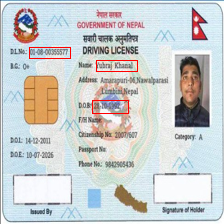

In [7]:
import numpy as np

target_size = 224
resized_image = image.copy().resize((target_size, target_size))

def resize_bounding_box(bbox, original_image, target_size):
  x_, y_ = original_image.size

  x_scale = target_size / x_ 
  y_scale = target_size / y_
  
  origLeft, origTop, origRight, origBottom = tuple(bbox)
  
  x = int(np.round(origLeft * x_scale))
  y = int(np.round(origTop * y_scale))
  xmax = int(np.round(origRight * x_scale))
  ymax = int(np.round(origBottom * y_scale))
  
  return [x, y, xmax, ymax]

resized_bounding_boxes = [resize_bounding_box(bbox, image, target_size) for bbox in bounding_boxes]

draw = ImageDraw.Draw(resized_image, "RGBA")
for bbox in resized_bounding_boxes:
    draw.rectangle(bbox, outline='red', width=1)

resized_image

In [8]:
from torchvision.transforms import ToTensor

image = ToTensor()(resized_image).unsqueeze(0) # batch size of 1
image.shape

torch.Size([1, 3, 224, 224])

In [9]:
import torch
import torchvision
from torchvision.transforms import ToTensor

# load resnet101 model and remove the last layer
model = torchvision.models.resnet101(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-3]))

with torch.no_grad():
    feature_map = model(image)

print(feature_map.size())

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

torch.Size([1, 1024, 14, 14])


In [10]:
import torch
from torchvision.ops import RoIAlign

output_size = (3,3)
spatial_scale = feature_map.shape[2]/target_size # 14/224
sampling_ratio = 2  

roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)

def align_bounding_boxes(bounding_boxes):
    aligned_bounding_boxes = []
    for bbox in bounding_boxes:
        aligned_bbox = [bbox[0] - 0.5, bbox[1] - 0.5, bbox[2] + 0.5, bbox[3] + 0.5]
        aligned_bounding_boxes.append(aligned_bbox)

    return aligned_bounding_boxes

feature_maps_bboxes = roi_align(input=feature_map, 
                                # we pass in a single tensor, with each bounding box also containing the batch index (0)
                                # We also add -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                # see https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch
                                rois=torch.tensor([[0] + bbox for bbox in align_bounding_boxes(resized_bounding_boxes)]).float()
                      )
print(feature_maps_bboxes.shape)

torch.Size([3, 1024, 3, 3])


In [11]:
visual_embeddings = torch.flatten(feature_maps_bboxes, 1)
visual_embeddings.shape

torch.Size([3, 9216])

In [12]:
import torch.nn as nn

projection = nn.Linear(in_features=visual_embeddings.shape[-1], out_features=768)
output = projection(visual_embeddings)
print(output.shape)

torch.Size([3, 768])


In [13]:
from os import listdir

image_files_train = [f for f in listdir("training_data/images")]


image_files_test = [f for f in listdir("testing_data/images")]

In [14]:
labels = ['B-Name','I-Name', 'B-DOB','I-DOB', 'B-LiscenseNo', 'I-LiscenseNo']
labels

['B-Name', 'I-Name', 'B-DOB', 'I-DOB', 'B-LiscenseNo', 'I-LiscenseNo']

In [15]:
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'B-Name': 0,
 'I-Name': 1,
 'B-DOB': 2,
 'I-DOB': 3,
 'B-LiscenseNo': 4,
 'I-LiscenseNo': 5}

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import numpy as np
from torchvision.transforms import ToTensor
import torch
import os

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]
    
def resize_and_align_bounding_box(bbox, original_image, target_size):
  x_, y_ = original_image.size

  x_scale = target_size / x_ 
  y_scale = target_size / y_
  
  origLeft, origTop, origRight, origBottom = tuple(bbox)
  
  x = int(np.round(origLeft * x_scale))
  y = int(np.round(origTop * y_scale))
  xmax = int(np.round(origRight * x_scale))
  ymax = int(np.round(origBottom * y_scale)) 
  
  return [x-0.5, y-0.5, xmax+0.5, ymax+0.5]

In [17]:
class DocDataset(Dataset):
    def __init__(self, image_file_names, tokenizer, max_length, target_size, train=True):
        self.image_file_names = image_file_names
        self.tokenizer = tokenizer
        self.max_seq_length = max_length
        self.target_size = target_size
        self.pad_token_box = [0, 0, 0, 0]
        self.train = train
        
    def __len__(self):
        return len(self.image_file_names)
    
    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        if self.train:
          base_path = f"{os.getcwd()}/training_data"
        else:
          base_path = f"{os.getcwd()}/testing_data"
        
        original_image = Image.open(base_path + "/images/" + item).convert("RGB")
        resized_image = original_image.resize((self.target_size, self.target_size))
        
        with open(base_path + '/annotations/' + item[:-4] + '.json') as f:
            data = json.load(f)
        words = []
        unnormalized_word_boxes = []
        word_labels = []
        
        for label in data['label']:
            unnormalized_word_boxes.append([label["x"] * label["original_width"] / 100, label["y"] * label["original_height"] / 100, (label["x"] + label["width"]) * label["original_width"] / 100, (label["y"] + label["height"]) * label["original_height"] / 100])
            word_labels.append(label["labels"][0])

        for transcription in data['transcription']:
            words.append(transcription)
            
        width, height = original_image.size
        normalized_word_boxes = [normalize_box(bbox, width, height) for bbox in unnormalized_word_boxes]
        assert len(words) == len(normalized_word_boxes)
        
        token_boxes = []
        unnormalized_token_boxes = []
        token_labels = []
        for word, unnormalized_box, box, label in zip(words, unnormalized_word_boxes, normalized_word_boxes, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            unnormalized_token_boxes.extend(unnormalized_box for _ in range(len(word_tokens)))
            token_boxes.extend(box for _ in range(len(word_tokens)))
            
            for i in range(len(word_tokens)):
                if i == 0:
                    token_labels.extend(['B-' + label])
                else:
                    token_labels.extend(['I-' + label])
                    
        special_tokens_count = 2
        if len(token_boxes) > self.max_seq_length - special_tokens_count:
            token_boxes = token_boxes[: (self.max_seq_length - special_tokens_count)]
            unnormalized_token_boxes = unnormalized_token_boxes[: (self.max_seq_length - special_tokens_count)]
            token_labels = token_labels[: (self.max_seq_length - special_tokens_count)]
        
        token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
        unnormalized_token_boxes = [[0, 0, 0, 0]] + unnormalized_token_boxes + [[1000, 1000, 1000, 1000]]
        token_labels = [-100] + token_labels + [-100]
        
        encoding = self.tokenizer(' '.join(words), padding='max_length', truncation=True)
        
        input_ids = self.tokenizer(' '.join(words), truncation=True)["input_ids"]
        padding_length = self.max_seq_length - len(input_ids)
        token_boxes += [self.pad_token_box] * padding_length
        unnormalized_token_boxes += [self.pad_token_box] * padding_length
        token_labels += [-100] * padding_length
        encoding['bbox'] = token_boxes
        encoding['labels'] = token_labels
        
        assert len(encoding['input_ids']) == self.max_seq_length
        assert len(encoding['attention_mask']) == self.max_seq_length
        assert len(encoding['token_type_ids']) == self.max_seq_length
        assert len(encoding['bbox']) == self.max_seq_length
        assert len(encoding['labels']) == self.max_seq_length
        
        encoding['resized_image'] = ToTensor()(resized_image)
        encoding['resized_and_aligned_bounding_boxes'] = [resize_and_align_bounding_box(bbox, original_image, self.target_size) 
                                                          for bbox in unnormalized_token_boxes]
        
        encoding['unnormalized_token_boxes'] = unnormalized_token_boxes
        
        for k,v in encoding.items():
            if k == 'labels':
              label_indices = []
              # convert labels from string to indices
              for label in encoding[k]:
                if label != -100:
                  label_indices.append(label2idx[label])
                else:
                  label_indices.append(label)
              encoding[k] = label_indices
            encoding[k] = torch.as_tensor(encoding[k])
            
        return encoding

In [18]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = DocDataset(image_file_names=image_files_train, tokenizer=tokenizer, max_length=512, target_size=224)

In [19]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'resized_image', 'resized_and_aligned_bounding_boxes', 'unnormalized_token_boxes'])

In [20]:
tokenizer.decode(encoding.input_ids)

'[CLS] 01 - 08 - 00355577 yubraj khanal 28 - 10 - 1992 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [21]:
encoding['resized_image'].shape

torch.Size([3, 224, 224])

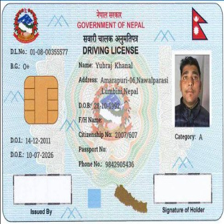

In [22]:
from torchvision.transforms import ToPILImage

test_image = ToPILImage()(encoding['resized_image']).convert("RGB")
test_image

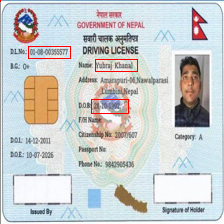

In [23]:
draw = ImageDraw.Draw(test_image, "RGBA")
for bbox in encoding['resized_and_aligned_bounding_boxes'].tolist():
    draw.rectangle(bbox, outline='red', width=1)

test_image

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=2)
batch = next(iter(train_dataloader))

In [25]:
for k, v in batch.items():
    print(k, batch[k].shape)

input_ids torch.Size([2, 512])
token_type_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
bbox torch.Size([2, 512, 4])
labels torch.Size([2, 512])
resized_image torch.Size([2, 3, 224, 224])
resized_and_aligned_bounding_boxes torch.Size([2, 512, 4])
unnormalized_token_boxes torch.Size([2, 512, 4])


In [26]:
for i in batch['resized_and_aligned_bounding_boxes']:
  print(i.shape)

torch.Size([512, 4])
torch.Size([512, 4])


In [27]:
import torch.nn as nn
from transformers.models.layoutlm import LayoutLMModel, LayoutLMConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torchvision
from torchvision.ops import RoIAlign

class LayoutLMForTokenClassification(nn.Module):
    def __init__(self, output_size=(3,3), 
                 spatial_scale=14/224, 
                 sampling_ratio=2
        ): 
        super().__init__()
        
        # LayoutLM base model + token classifier
        self.num_labels = len(label2idx)
        self.layoutlm = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=self.num_labels)
        self.dropout = nn.Dropout(self.layoutlm.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.layoutlm.config.hidden_size, self.num_labels)

        # backbone + roi-align + projection layer
        model = torchvision.models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*(list(model.children())[:-3]))
        self.roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)
        self.projection = nn.Linear(in_features=1024*3*3, out_features=self.layoutlm.config.hidden_size)

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask,
        token_type_ids,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        resized_images=None, # shape (N, C, H, W), with H = W = 224
        resized_and_aligned_bounding_boxes=None, # single torch tensor that also contains the batch index for every bbox at image size 224
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.

        """
        return_dict = return_dict if return_dict is not None else self.layoutlm.config.use_return_dict

        # first, forward pass on LayoutLM
        outputs = self.layoutlm(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # next, send resized images of shape (batch_size, 3, 224, 224) through backbone to get feature maps of images 
        # shape (batch_size, 1024, 14, 14)
        feature_maps = self.backbone(resized_images)
        
        # next, use roi align to get feature maps of individual (resized and aligned) bounding boxes
        # shape (batch_size*seq_len, 1024, 3, 3)
        device = input_ids.device
        resized_bounding_boxes_list = []
        for i in resized_and_aligned_bounding_boxes:
          resized_bounding_boxes_list.append(i.float().to(device))
                
        feat_maps_bboxes = self.roi_align(input=feature_maps, 
                                        # we pass in a list of tensors
                                        # We have also added -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                        # see https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch
                                        rois=resized_bounding_boxes_list
                           )  
      
        # next, reshape  + project to same dimension as LayoutLM. 
        batch_size = input_ids.shape[0]
        seq_len = input_ids.shape[1]
        feat_maps_bboxes = feat_maps_bboxes.view(batch_size, seq_len, -1) # Shape (batch_size, seq_len, 1024*3*3)
        projected_feat_maps_bboxes = self.projection(feat_maps_bboxes) # Shape (batch_size, seq_len, hidden_size)

        # add those to the sequence_output - shape (batch_size, seq_len, hidden_size)
        sequence_output += projected_feat_maps_bboxes

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [28]:
model = LayoutLMForTokenClassification()

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing LayoutLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed

In [29]:
input_ids=batch['input_ids']
bbox=batch['bbox']
attention_mask=batch['attention_mask']
token_type_ids=batch['token_type_ids']
labels=batch['labels']
resized_images = batch['resized_image'] # shape (N, C, H, W), with H = W = 224
resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'] # single torch tensor that also contains the batch index for every bbox at image size 224

outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

In [30]:
outputs.loss

tensor(1.8304, grad_fn=<NllLossBackward0>)

In [31]:
outputs.logits.shape

torch.Size([2, 512, 6])

In [32]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#put the model in training mode
model.to(device)
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
      # forward pass
      input_ids=batch['input_ids'].to(device)
      bbox=batch['bbox'].to(device)
      attention_mask=batch['attention_mask'].to(device)
      token_type_ids=batch['token_type_ids'].to(device)
      labels=batch['labels'].to(device)
      resized_images = batch['resized_image'].to(device) 
      resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) 

      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                      labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)
      loss = outputs.loss

      # print loss every 10 steps
      if global_step % 10 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 0 steps: 1.8682646751403809
Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 10 steps: 0.402189701795578
Epoch: 4


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 20 steps: 0.04858363792300224
Epoch: 7


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
test_dataset = DocDataset(image_file_names=image_files_test, tokenizer=tokenizer, max_length=512, target_size=224, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [34]:
!pip install -q seqeval

In [35]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids=batch['input_ids'].to(device)
        bbox=batch['bbox'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        token_type_ids=batch['token_type_ids'].to(device)
        labels=batch['labels'].to(device)
        resized_images = batch['resized_image'].to(device) 
        resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) 

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                        labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != -100:
            out_label_list[i].append(idx2label[out_label_ids[i][j]])
            preds_list[i].append(idx2label[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': 0.12429893761873245, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


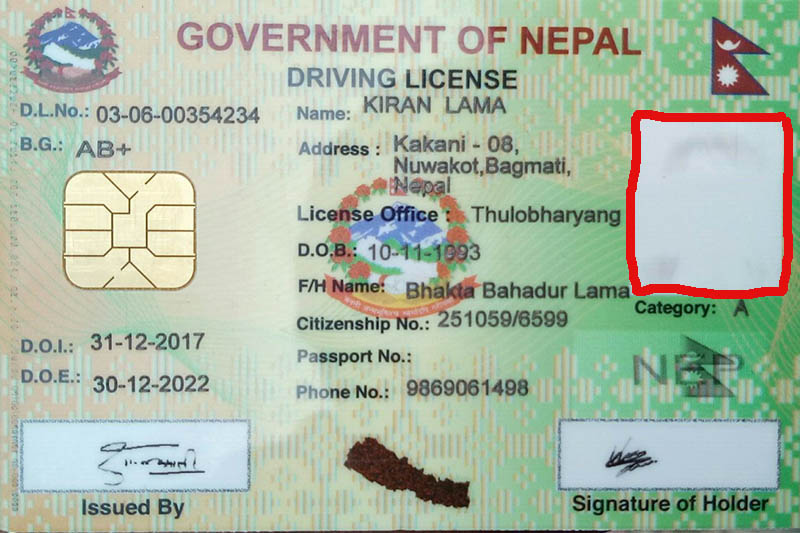

In [36]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("testing_data/images/1.jpg")
image = image.convert("RGB")
image

In [37]:
inference_dataset = DocDataset(image_file_names=["1.jpg"], tokenizer=tokenizer, max_length=512, target_size=224, train=False)
test_encoding = inference_dataset[0]
test_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'resized_image', 'resized_and_aligned_bounding_boxes', 'unnormalized_token_boxes'])

In [38]:
for k,v in test_encoding.items():
  test_encoding[k] = test_encoding[k].unsqueeze(0).to(device)

input_ids=test_encoding['input_ids']
bbox=test_encoding['bbox']
attention_mask=test_encoding['attention_mask']
token_type_ids=test_encoding['token_type_ids']
labels=test_encoding['labels']
resized_images = test_encoding['resized_image']
resized_and_aligned_bounding_boxes = test_encoding['resized_and_aligned_bounding_boxes']

In [39]:
for k,v in test_encoding.items():
  print(test_encoding[k].shape)

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512, 4])
torch.Size([1, 512])
torch.Size([1, 3, 224, 224])
torch.Size([1, 512, 4])
torch.Size([1, 512, 4])


In [40]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

In [41]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
token_actual_boxes = test_encoding['unnormalized_token_boxes'].squeeze().tolist()

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

print(word_level_predictions)
print(final_boxes)

[4, 5, 5, 5, 5, 0, 1, 3, 3, 3, 3, 3]
[[92.48401641845703, 92.48401641845703, 272.58447265625, 131.42465209960938], [92.48401641845703, 92.48401641845703, 272.58447265625, 131.42465209960938], [92.48401641845703, 92.48401641845703, 272.58447265625, 131.42465209960938], [92.48401641845703, 92.48401641845703, 272.58447265625, 131.42465209960938], [92.48401641845703, 92.48401641845703, 272.58447265625, 131.42465209960938], [362.63470458984375, 92.48401641845703, 524.4817504882812, 126.55707550048828], [362.63470458984375, 92.48401641845703, 524.4817504882812, 126.55707550048828], [366.285400390625, 234.86073303222656, 512.3128051757812, 268.93377685546875], [366.285400390625, 234.86073303222656, 512.3128051757812, 268.93377685546875], [366.285400390625, 234.86073303222656, 512.3128051757812, 268.93377685546875], [366.285400390625, 234.86073303222656, 512.3128051757812, 268.93377685546875], [366.285400390625, 234.86073303222656, 512.3128051757812, 268.93377685546875]]


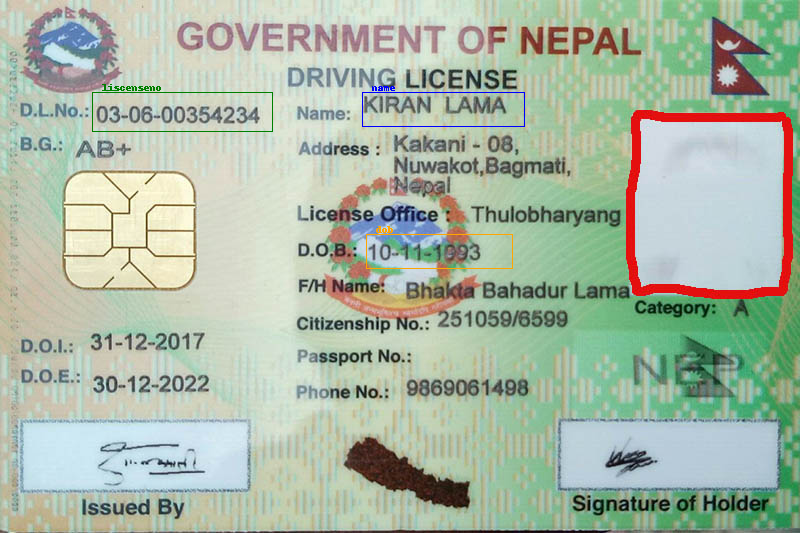

In [42]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    return label[2:]

label2color = {'name':'blue', 'liscenseno':'green', 'dob':'orange'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(idx2label[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image